In [10]:
import tensorflow as tf
from tensorflow import keras 
import keras_preprocessing

import matplotlib.pyplot as plt
import numpy as np

import os
import random
import cv2
import scipy


In [3]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)

batch_size = 128

In [4]:
base_dir = "New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(base_dir,"train")
test_dir = os.path.join(base_dir,"valid")


In [5]:
train_datagen = keras_preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                             shear_range = 0.2,
                                                             zoom_range = 0.2,
                                                             width_shift_range = 0.2,
                                                             height_shift_range = 0.2,
                                                             fill_mode="nearest")

test_datagen = keras_preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

In [6]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (image_size, image_size),
                                               batch_size = 128,
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (image_size, image_size),
                                             batch_size = 128,
                                             class_mode = "categorical")

x,y = test_data.next()

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [6]:
train_num = train_data.samples
test_num = test_data.samples

In [7]:
categories = list(train_data.class_indices.keys())
print(train_data.class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [8]:
mobile_net_base_model = tf.keras.applications.MobileNet(weights = "imagenet",
                                             include_top = False,
                                             input_shape = input_shape)

mobile_net_base_model.trainable = False

In [12]:
inputs = keras.Input(shape = input_shape)

x = mobile_net_base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(categories), 
                          activation="softmax")(x)

mobileNetModel = keras.Model(inputs = inputs, 
                    outputs = x, 
                    name="LeafDisease_MobileNet")

In [13]:
optimizer = tf.keras.optimizers.Adam()

mobileNetModel.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=[keras.metrics.CategoricalAccuracy(), 
                       'accuracy'])

In [14]:
mobileNetHistory = mobileNetModel.fit(train_data,
                    validation_data=test_data,
                    epochs=10,
                    steps_per_epoch=train_num//batch_size,
                    validation_steps=test_num//batch_size)

NameError: name 'train_num' is not defined

In [20]:
mobileNetModel.save('models/mobileNetModel.h5')

model = tf.keras.models.load_model('models/mobileNetModel.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflmodel = converter.convert()
file = open( 'mobileNetModel.tflite' , 'wb' ) 
file.write( tflmodel )

INFO:tensorflow:Assets written to: C:\Users\ANUBHA~1\AppData\Local\Temp\tmp12qub4ni\assets


12962516

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(10)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
plot_history(mobileNetHistory)

In [ ]:
resnet_base_model = tf.keras.applications.ResNet50V2(weights = "imagenet",
                                             include_top = False,
                                             input_shape = input_shape)

resnet_base_model.trainable = False

In [ ]:
inputs = keras.Input(shape = input_shape)

x = resnet_base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(categories), 
                          activation="softmax")(x)

resNetModel = keras.Model(inputs = inputs, 
                    outputs = x, 
                    name="LeafDisease_ResNet")

In [ ]:
optimizer = tf.keras.optimizers.Adam()

resNetModel.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=[keras.metrics.CategoricalAccuracy(), 
                       'accuracy'])

In [ ]:
resNetHistory = resNetModel.fit(train_data,
                    validation_data=test_data,
                    epochs=8,
                    steps_per_epoch=train_num//batch_size,
                    validation_steps=test_num//batch_size)
resNetModel.save('models/resNetModel.h5')


In [ ]:
plot_history(resNetHistory)

In [ ]:
InceptionV3_base_model = tf.keras.applications.InceptionV3(weights = "imagenet",
                                             include_top = False,
                                             input_shape = input_shape)

InceptionV3_base_model.trainable = False

In [ ]:
inputs = keras.Input(shape = input_shape)

x = InceptionV3_base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(categories))(x)

InceptionV3Model = keras.Model(inputs = inputs, 
                    outputs = x, 
                    name="LeafDisease_InceptionV3")

In [ ]:
optimizer = tf.keras.optimizers.Adam()
InceptionV3Model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=[keras.metrics.CategoricalAccuracy(), 
                       'accuracy'])

In [ ]:
InceptionV3History = InceptionV3Model.fit(train_data,
                    validation_data=test_data,
                    epochs=10,
                    steps_per_epoch=train_num//batch_size,
                    validation_steps=test_num//batch_size)
InceptionV3Model.save('models/InceptionV3.h5')


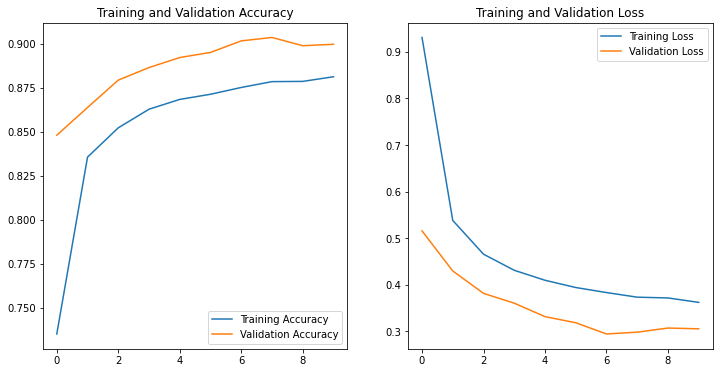

In [ ]:
plot_history(InceptionV3History)

In [ ]:
def load_all_models():
    all_models = []
    model_names = ['mobileNet.h5', 'resNet.h5', 'InceptionV3.h5']
    i=10
    for model_name in model_names:
        filename = os.path.join('models', model_name)
        model = tf.keras.models.load_model(filename)
        i=i+1
        all_models.append(model)
        print('loaded:', filename)
    return all_models

In [ ]:
models = load_all_models()

In [ ]:
# Ensemble Prediction
testingDataGen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)
dir = "./test"
testingImages = testingDataGen.flow_from_directory(dir,
                                             target_size = (image_size, image_size),
                                             batch_size = 1,
                                             shuffle=False,
                                             class_mode = "categorical")
print(testingImages.filenames)
yhats = [model.predict(testingImages) for model in models]
yhats = np.array(yhats)
# sum across ensemble members
summed = np.sum(yhats, axis=0)
# argmax across classes
result = np.argmax(summed, axis=1)
print(result)

In [ ]:
y_test = [0,0,0,0,0]
y_test = np.array(y_test)
count = 0
pos = 5
for i in range(5,190):
    temp = np.insert(y_test,pos,i//5)
    y_test = temp
    pos+=1
y_test

In [ ]:
from IPython.display import Image
display = []
i = 0
while(i < 190):
    path = testingImages.filenames[i] 
    path.split("\\")[1]
    display.append(Image("./test/test/"+path.split("\\")[1]))
    i+=5    


In [ ]:
print("Actual Class", y_test[0])
print("Predicted Class",result[0])
display[0]

In [ ]:
print("Actual Class", y_test[5])
print("Predicted Class",result[5])
display[1]

In [ ]:
print("Actual Class", y_test[10])
print("Predicted Class",result[10])
display[2]

In [ ]:
print("Actual Class", y_test[15])
print("Predicted Class",result[15])
display[3]

In [ ]:
print("Actual Class", y_test[20])
print("Predicted Class",result[20])
display[4]

In [ ]:
print("Actual Class", y_test[25])
print("Predicted Class",result[25])
display[5]

In [ ]:
print("Actual Class", y_test[30])
print("Predicted Class",result[30])
display[6]

Actual Class 7
Predicted Class 7


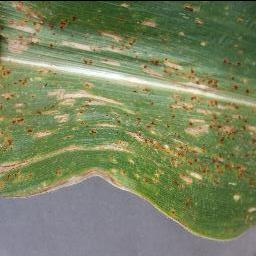

In [ ]:
print("Actual Class", y_test[35])
print("Predicted Class",result[35])
display[7]

Actual Class 8
Predicted Class 8


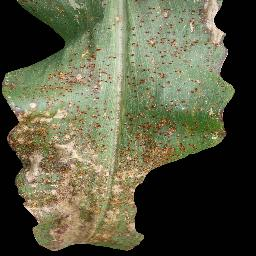

In [ ]:
print("Actual Class", y_test[40])
print("Predicted Class",result[40])
display[8]

Actual Class 9
Predicted Class 9


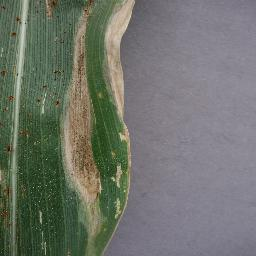

In [ ]:
print("Actual Class", y_test[45])
print("Predicted Class",result[45])
display[9]

Actual Class 10
Predicted Class 10


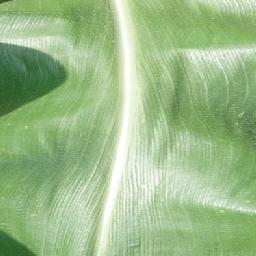

In [ ]:
print("Actual Class", y_test[50])
print("Predicted Class",result[50])
display[10]

Actual Class 11
Predicted Class 11


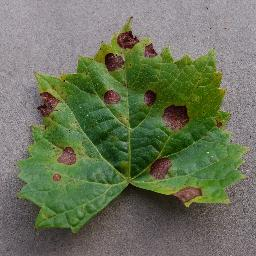

In [ ]:
print("Actual Class", y_test[55])
print("Predicted Class",result[55])
display[11]

Actual Class 36
Predicted Class 36


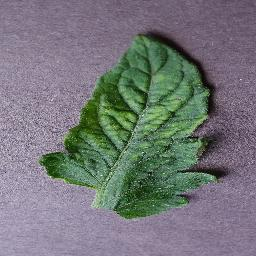

In [ ]:
print("Actual Class", y_test[180])
print("Predicted Class",result[180])
display[36]

Actual Class 12
Predicted Class 12


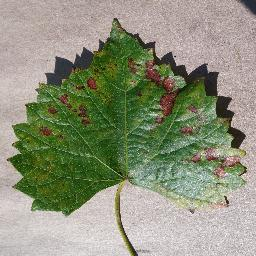

In [ ]:
print("Actual Class", y_test[60])
print("Predicted Class",result[60])
display[12]

Actual Class 13
Predicted Class 13


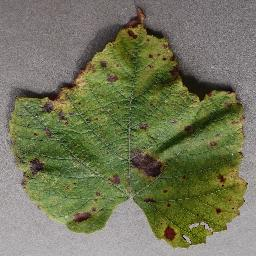

In [ ]:
print("Actual Class", y_test[65])
print("Predicted Class",result[65])
display[13]

Actual Class 18
Predicted Class 19


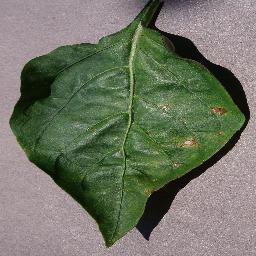

In [ ]:
print("Actual Class", y_test[90])
print("Predicted Class",result[90])
display[18]

Actual Class 30
Predicted Class 29


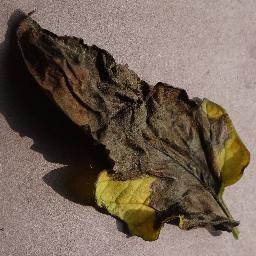

In [ ]:
print("Actual Class", y_test[151])
print("Predicted Class",result[151])
display[30]

Actual Class 32
Predicted Class 24


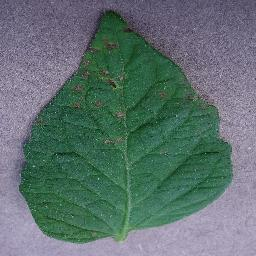

In [ ]:
print("Actual Class", y_test[160])
print("Predicted Class",result[160])
display[32]

Actual Class 34
Predicted Class 32


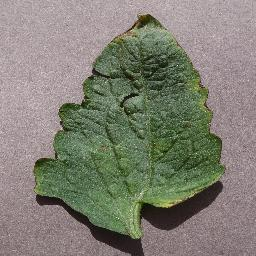

In [ ]:
print("Actual Class", y_test[170])
print("Predicted Class",result[170])
display[34]

Actual Class 35
Predicted Class 35


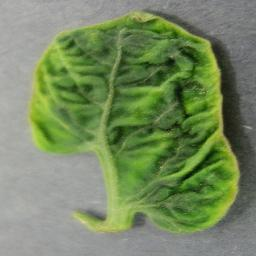

In [ ]:
print("Actual Class", y_test[176])
print("Predicted Class",result[176])
display[35]

In [ ]:
from sklearn.metrics import recall_score, precision_score, accuracy_score,f1_score
mob_res = models[0].predict(testingImages)
mob_pred = np.argmax(mob_res,axis=1)
#print(mob_pred)
accuracy_mob = accuracy_score(y_test,mob_pred)
print("Accuracy for mobilenet - ",accuracy_mob)
precision_mob = precision_score(y_test,mob_pred,average='weighted')
print("Precision Score for mobilenet - ",precision_mob)
recall_mob = recall_score(y_test,mob_pred,average='weighted')
print("Recall Score for Mobilenet - ",recall_mob)
f1_mob = f1_score(y_test,mob_pred,average='weighted')
print("F1 Score for Mobilenet - ",f1_mob)

Accuracy for mobilenet -  0.9421052631578948
Precision Score for mobilenet -  0.9333333333333333
Recall Score for Mobilenet -  0.9421052631578948
F1 Score for Mobilenet -  0.9272195640616692


C:\anaconda_install\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


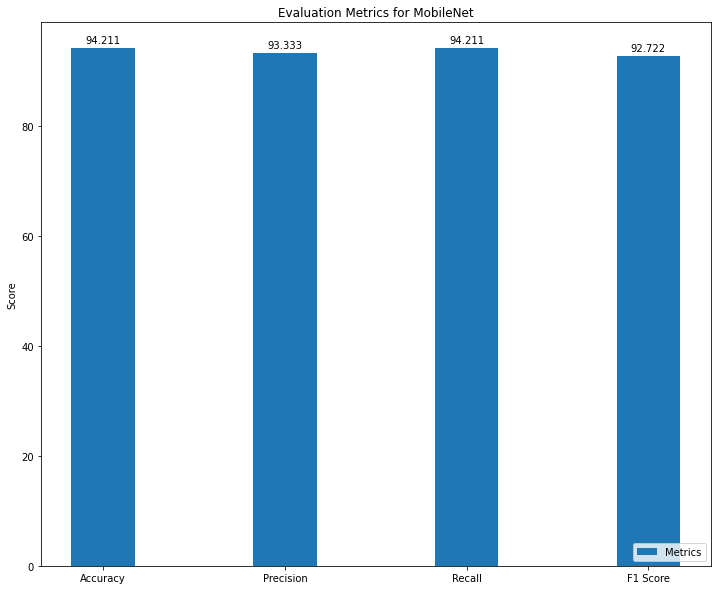

In [ ]:
names = ['Accuracy','Precision',"Recall",'F1 Score']
score = [round((accuracy_mob*100),3),round((precision_mob*100),3),round((recall_mob*100),3),round((f1_mob*100),3)]
x = np.arange(len(names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize =(12, 10))
rects2 = ax.bar(x, score, width, label='Metrics')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics for MobileNet')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend(loc= 'lower right')

def autolabel(rects):

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects2)

plt.show()

In [ ]:
resnet_res = models[1].predict(testingImages)
resnet_pred = np.argmax(resnet_res,axis=1)

accuracy_resnet = accuracy_score(y_test,resnet_pred)
print("Accuracy for Resnet - ",accuracy_resnet)
precision_resnet = precision_score(y_test,resnet_pred,average='weighted')
print("Precision Score for Resnet - ",precision_resnet)
recall_resnet = recall_score(y_test,resnet_pred,average='weighted')
print("Recall Score for Resnet - ",recall_resnet)
f1_resnet = f1_score(y_test,resnet_pred,average='weighted')
print("F1 Score for Mobilenet - ",f1_resnet)

Accuracy for Resnet -  0.9473684210526315
Precision Score for Resnet -  0.9592731829573933
Recall Score for Resnet -  0.9473684210526315
F1 Score for Mobilenet -  0.9435520619731145


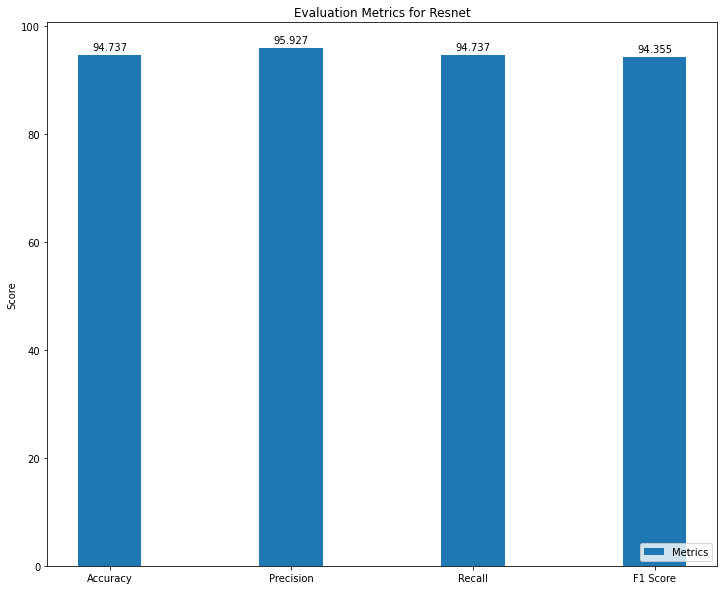

In [ ]:
names = ['Accuracy','Precision',"Recall",'F1 Score']
score = [round((accuracy_resnet*100),3),round((precision_resnet*100),3),round((recall_resnet*100),3),round((f1_resnet*100),3)]
x = np.arange(len(names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize =(12, 10))
rects2 = ax.bar(x, score, width, label='Metrics')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics for Resnet')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend(loc= 'lower right')

def autolabel(rects):

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects2)

plt.show()

In [ ]:
inception_res = models[2].predict(testingImages)
inception_pred = np.argmax(inception_res,axis=1)

accuracy_inception = accuracy_score(y_test,inception_pred)
print("Accuracy for InceptionV3 - ",accuracy_inception)
precision_inception = precision_score(y_test,inception_pred,average='weighted')
print("Precision Score for InceptionV3 - ",precision_inception)
recall_inception = recall_score(y_test,inception_pred,average='weighted')
print("Recall Score for InceptionV3 - ",recall_inception)
f1_inception = f1_score(y_test,inception_pred,average='weighted')
print("F1 Score for Mobilenet - ",f1_inception)

Accuracy for InceptionV3 -  0.9
Precision Score for InceptionV3 -  0.9136904761904764
Recall Score for InceptionV3 -  0.9
F1 Score for Mobilenet -  0.8973884302831672


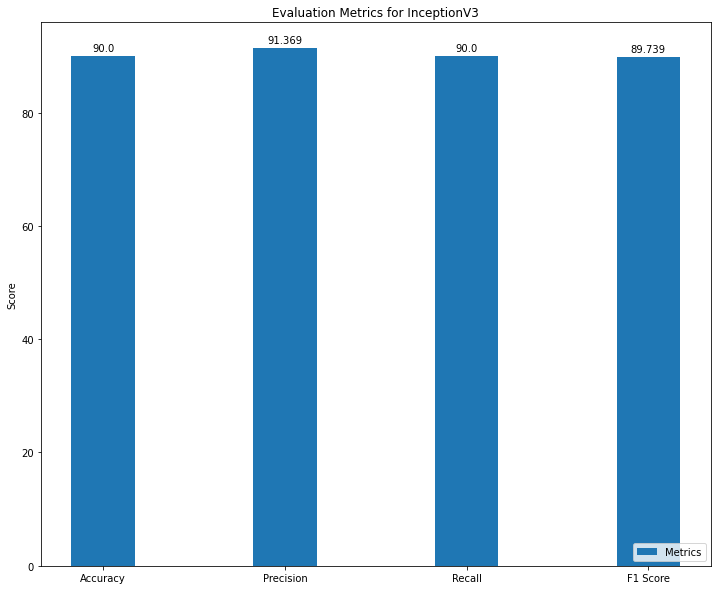

In [ ]:
names = ['Accuracy','Precision',"Recall",'F1 Score']
score = [round((accuracy_inception*100),3),round((precision_inception*100),3),round((recall_inception*100),3),round((f1_inception*100),3)]
x = np.arange(len(names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize =(12, 10))
rects2 = ax.bar(x, score, width, label='Metrics')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics for InceptionV3')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend(loc= 'lower right')

def autolabel(rects):

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects2)

plt.show()

In [ ]:
count = 0
error = 0
for i in result:
    res = count//5
    count+=1
    if(res != i):
        error+=1

#print(error)
accuracy = ((count-error)/count)*100
print("Accuracy -",accuracy,'%')

Accuracy - 95.78947368421052 %


In [ ]:
y_test = [0,0,0,0,0]
y_test = np.array(y_test)
count = 0
pos = 5
for i in range(5,190):
    temp = np.insert(y_test,pos,i//5)
    y_test = temp
    pos+=1
y_test


array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13,
       13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20,
       20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23,
       23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27,
       27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 30, 30,
       30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
       34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 37, 37,
       37, 37, 37])

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, jaccard_score, cohen_kappa_score
#print(classification_report(y_test,result))
print("Precision score - ",precision_score(y_test,result,average='weighted'))
print("Recall score - ",recall_score(y_test,result,average='weighted'))
print("Accuracy score - ",accuracy_score(y_test,result))
print("Jaccard score - ",jaccard_score(y_test,result,average='weighted'))
print("F1 score - ",f1_score(y_test,result,average='weighted'))
print("Cohen Kappa Score - ",cohen_kappa_score(y_test,result))


Precision score -  0.9609022556390978
Recall score -  0.9578947368421052
Accuracy score -  0.9578947368421052
Jaccard score -  0.9275689223057644
F1 score -  0.9551967038809144
Cohen Kappa Score -  0.9567567567567568


Text(0, 0.5, 'Score')

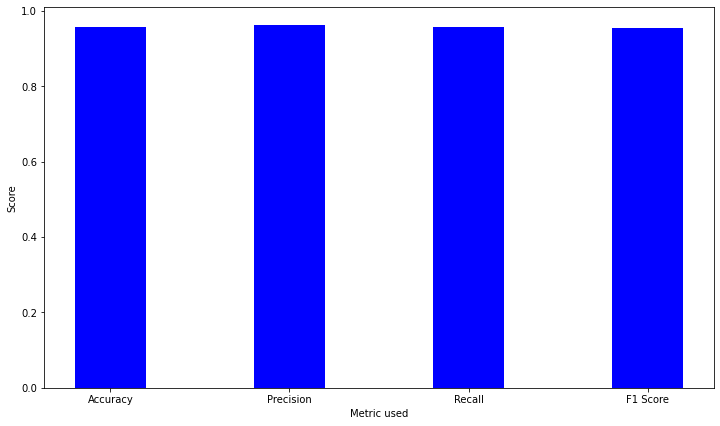

In [ ]:
metrics = {'Accuracy':accuracy_score(y_test,result),'Precision':precision_score(y_test,result,average='weighted'),'Recall':recall_score(y_test,result,average='weighted'),'F1 Score':f1_score(y_test,result,average='weighted')}
names = metrics.keys()
score = metrics.values()
fig = plt.figure(figsize = (12, 7))
 
# creating the bar plot
plt.bar(names, score, color ='blue',width = 0.4)
plt.xlabel('Metric used')
plt.ylabel('Score')



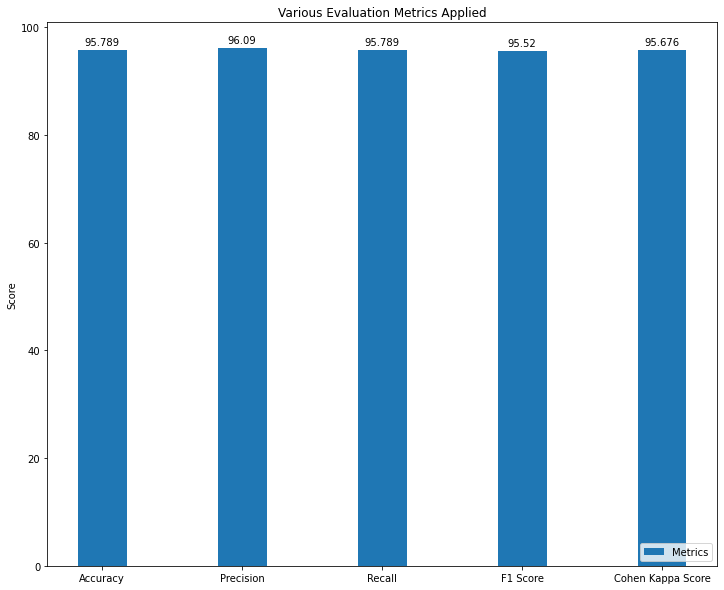

In [ ]:
names = ['Accuracy','Precision',"Recall",'F1 Score','Cohen Kappa Score']
score = [round(accuracy_score(y_test,result)*100,3),round(precision_score(y_test,result,average='weighted')*100,3),round(recall_score(y_test,result,average='weighted')*100,3),round(f1_score(y_test,result,average='weighted')*100,3),round(cohen_kappa_score(y_test,result)*100,3)]
score_a = [round(score[0]*100,4), round(score[1]*100,3), round(score[2]*100,23), round(score[3]*100,3)]
x = np.arange(len(names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize =(12, 10))
rects2 = ax.bar(x, score, width, label='Metrics')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Various Evaluation Metrics Applied')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend(loc= 'lower right')

def autolabel(rects):

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects2)

plt.show()

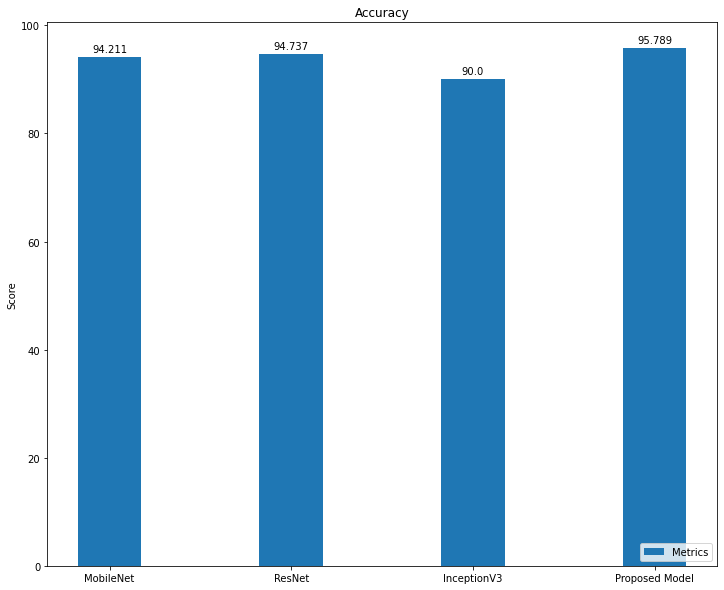

In [ ]:
names = ['MobileNet','ResNet',"InceptionV3",'Proposed Model']
score = [round((accuracy_mob*100),3),round((accuracy_resnet*100),3),round((accuracy_inception*100),3),round((accuracy_score(y_test,result)*100),3)]
x = np.arange(len(names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize =(12, 10))
rects2 = ax.bar(x, score, width, label='Metrics')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend(loc= 'lower right')

def autolabel(rects):

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects2)

plt.show()

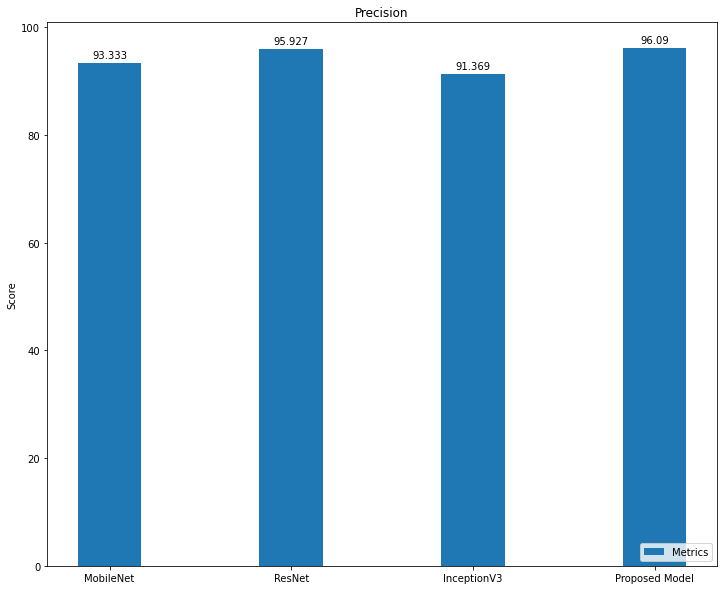

In [ ]:
names = ['MobileNet','ResNet',"InceptionV3",'Proposed Model']
score = [round((precision_mob*100),3),round((precision_resnet*100),3),round((precision_inception*100),3),round((precision_score(y_test,result,average='weighted')*100),3)]
x = np.arange(len(names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize =(12, 10))
rects2 = ax.bar(x, score, width, label='Metrics')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Precision')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend(loc= 'lower right')

def autolabel(rects):

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects2)

plt.show()

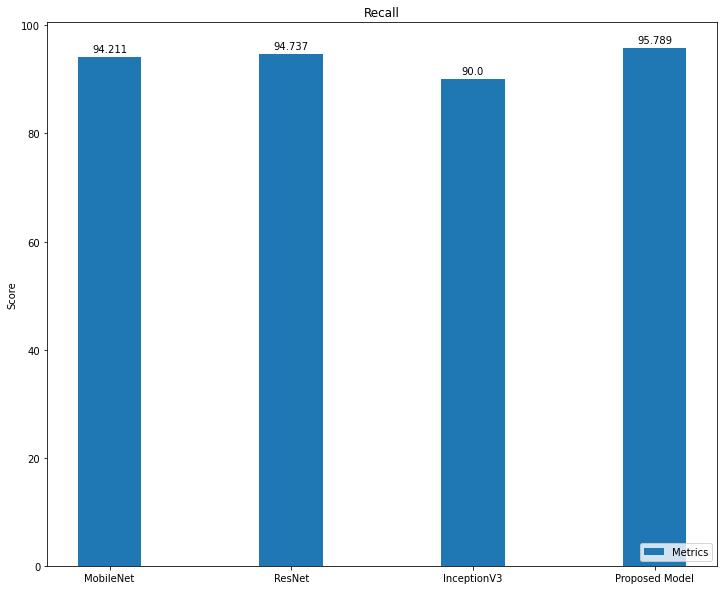

In [ ]:
names = ['MobileNet','ResNet',"InceptionV3",'Proposed Model']
score = [round((recall_mob*100),3),round((recall_resnet*100),3),round((recall_inception*100),3),round((recall_score(y_test,result,average='weighted')*100),3)]
x = np.arange(len(names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize =(12, 10))
rects2 = ax.bar(x, score, width, label='Metrics')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Recall')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend(loc= 'lower right')

def autolabel(rects):

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects2)

plt.show()

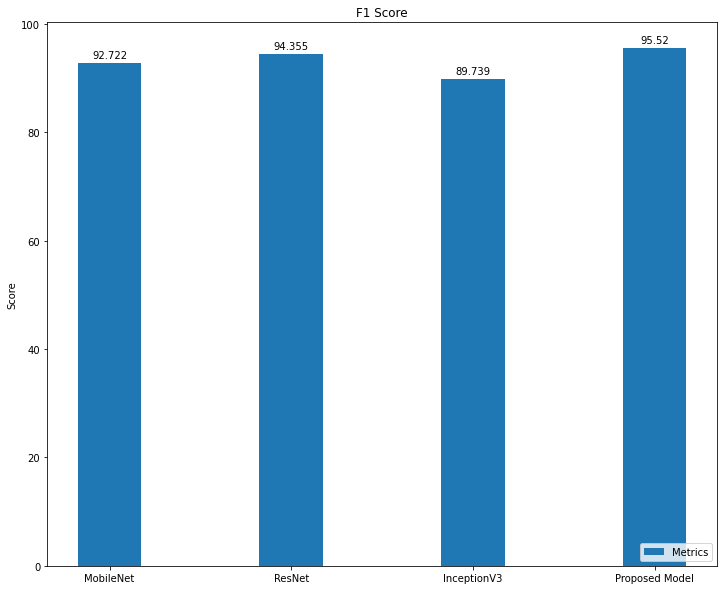

In [ ]:
names = ['MobileNet','ResNet',"InceptionV3",'Proposed Model']
score = [round((f1_mob*100),3),round((f1_resnet*100),3),round((f1_inception*100),3),round((f1_score(y_test,result,average='weighted')*100),3)]
x = np.arange(len(names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize =(12, 10))
rects2 = ax.bar(x, score, width, label='Metrics')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('F1 Score')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend(loc= 'lower right')

def autolabel(rects):

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects2)

plt.show()